In [1]:
print('LOL')

LOL


In [2]:
import pandas as pd

# Загрузка CSV-файла в DataFrame
df = pd.read_csv('transactions_diy.csv')

# Преобразование колонки 'tr_date' в тип datetime
#df['tr_date'] = pd.to_datetime(df['tr_date'])
df['trDte'] = pd.to_datetime(df['trDte'],format = '%d.%m.%Y')

# Вывод первых 5 строк
print(df.head())

# Вывод основной информации о датасете
print(df.info())

       trDte          bcode     clientID      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                      itemGroup  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008688 entries, 0 to 1008687
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   trDte      1008688 non-null  datetime64[ns]
 1   bcode      1008688 non-null  object        
 2   clientID   1008688 non-null  object        
 3   i

In [5]:
"""
EDA-скрипт для анализа транзакций продаж.
Выполняет:
- Загрузку и валидацию данных
- Преобразование типов
- Базовую статистику по датасету
- Проверку пропусков и диапазонов
Автор: Data Analyst
Версия: 1.1
"""

import pandas as pd
from typing import List

# Настройка отображения
pd.set_option('display.float_format', '{:.2f}'.format)

# Константы
FILE_PATH = 'transactions_diy.csv'
EXPECTED_COLUMNS = ['trDte', 'bcode', 'clientID', 'item', 'itemGroup', 'quantity', 'amount']
DATE_FORMAT = '%d.%m.%Y'
NUMERIC_COLS = ['quantity', 'amount']


def load_and_validate_data(filepath: str) -> pd.DataFrame:
    """
    Загружает CSV-файл и проверяет целостность данных.
    
    Параметры:
        filepath (str): путь к файлу
        
    Возвращает:
        pd.DataFrame: валидированный DataFrame
        
    Вызывает:
        FileNotFoundError: если файл не найден
        ValueError: если колонки не совпадают или данные пусты
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл не найден: {filepath}. Проверьте путь.")
    except pd.errors.EmptyDataError:
        raise ValueError("Файл пуст.")
    except Exception as e:
        raise RuntimeError(f"Ошибка при чтении файла: {e}")

    # Валидация колонок
    missing_cols = set(EXPECTED_COLUMNS) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Отсутствуют ожидаемые колонки: {missing_cols}")

    if df.empty:
        raise ValueError("Загруженный DataFrame пуст.")

    print(f"✅ Файл '{filepath}' загружен. {len(df)} строк, {len(df.columns)} колонок.")
    return df


def convert_date_column(df: pd.DataFrame, date_col: str = 'trDte') -> pd.DataFrame:
    """
    Преобразует колонку даты в datetime с проверкой.
    
    Параметры:
        df (pd.DataFrame): исходный DataFrame
        date_col (str): имя колонки с датой
        
    Возвращает:
        pd.DataFrame: с преобразованной датой
    """
    if date_col not in df.columns:
        raise ValueError(f"Колонка даты '{date_col}' отсутствует в данных.")
    
    try:
        df = df.copy()  # Избегаем SettingWithCopyWarning
        df[date_col] = pd.to_datetime(df[date_col], format=DATE_FORMAT, errors='coerce')
    except Exception as e:
        raise ValueError(f"Ошибка парсинга дат в колонке '{date_col}': {e}")
    
    # Проверка на некорректные даты
    invalid_dates = df[date_col].isna().sum()
    if invalid_dates > 0:
        print(f"⚠️  Обнаружено {invalid_dates} некорректных дат. Установлены как NaT.")
    
    print(f"✅ Колонка '{date_col}' преобразована в datetime.")
    return df


def print_dataset_info(df: pd.DataFrame, numeric_cols: List[str]):
    """
    Выводит основную статистику по датасету.
    
    Параметры:
        df (pd.DataFrame): данные
        numeric_cols (List[str]): числовые колонки для анализа
    """
    print("\n" + "="*50)
    print("📊 ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
    print("="*50)
    
    # 1. Общая информация
    print(f"🔹 Количество строк: {df.shape[0]:,}")
    print(f"🔹 Количество столбцов: {df.shape[1]}")
    print(f"\n🔹 Типы данных:\n{df.dtypes}")

    # 2. Описательная статистика
    print(f"\n\n🔹 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ({', '.join(numeric_cols)})")
    desc = df[numeric_cols].describe()
    print(desc.round(2))

    print(f"\n🔹 Медианы:")
    print(df[numeric_cols].median().map('{:.2f}'.format))

    # 3. Пропущенные значения
    print(f"\n\n🔹 ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    missing = df.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"  ⚠️  {col}: {count} пропусков")
    total_missing = missing.sum()
    print(f"  Всего пропущенных значений: {total_missing}")

    # 4. Уникальные значения и диапазоны
    print(f"\n\n🔹 УНИКАЛЬНЫЕ ЗНАЧЕНИЯ И ДИАПАЗОНЫ ({', '.join(numeric_cols)})")
    for col in numeric_cols:
        unique_count = df[col].nunique()
        min_val = df[col].min()
        max_val = df[col].max()
        range_val = max_val - min_val
        print(f"  {col}:")
        print(f"    • Уникальных значений: {unique_count:,}")
        print(f"    • Диапазон: [{min_val} ; {max_val}] (размах = {range_val})")


# ==================== ОСНОВНОЙ КОД ====================
if __name__ == "__main__":
    try:
        # Загрузка и валидация
        sales_df = load_and_validate_data(FILE_PATH)
        
        # Преобразование даты
        sales_df = convert_date_column(sales_df, 'trDte')
        
        # Вывод анализа
        print_dataset_info(sales_df, NUMERIC_COLS)
        
        print("\n✅ EDA завершён успешно.")
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")
        raise


✅ Файл 'transactions_diy.csv' загружен. 1008688 строк, 7 колонок.
✅ Колонка 'trDte' преобразована в datetime.

📊 ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ
🔹 Количество строк: 1,008,688
🔹 Количество столбцов: 7

🔹 Типы данных:
trDte        datetime64[ns]
bcode                object
clientID             object
item                 object
itemGroup            object
quantity              int64
amount                int64
dtype: object


🔹 ОПИСАТЕЛЬНАЯ СТАТИСТИКА (quantity, amount)
        quantity     amount
count 1008688.00 1008688.00
mean        2.22     623.19
std         5.03    1878.42
min         0.00       0.00
25%         1.00      56.00
50%         1.00     150.00
75%         2.00     425.00
max      1100.00  213177.00

🔹 Медианы:
quantity      1.00
amount      150.00
dtype: object


🔹 ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
  Всего пропущенных значений: 0


🔹 УНИКАЛЬНЫЕ ЗНАЧЕНИЯ И ДИАПАЗОНЫ (quantity, amount)
  quantity:
    • Уникальных значений: 198
    • Диапазон: [0 ; 1100] (размах = 1100)
  amount:
    

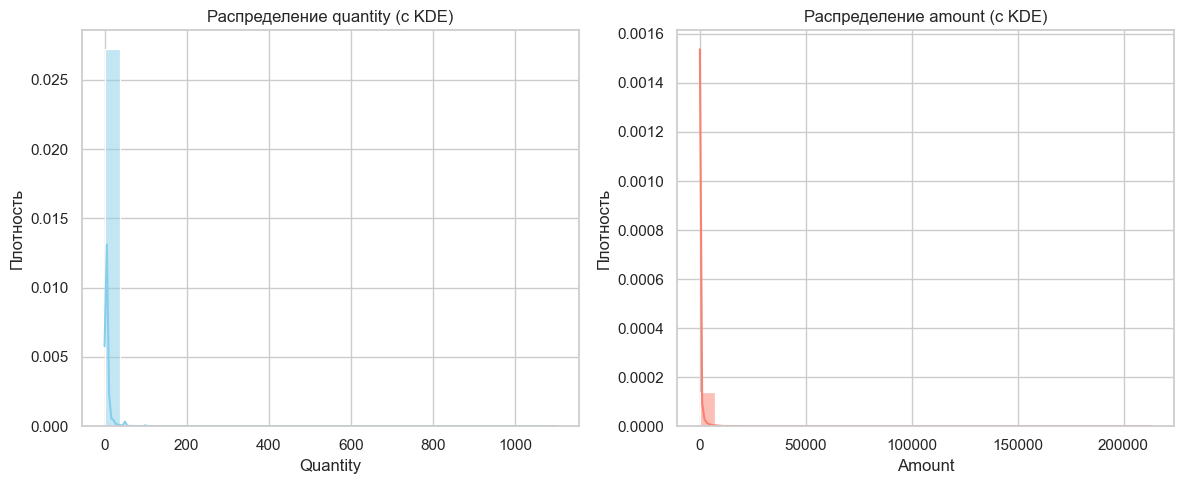

C:\Users\Dns\AppData\Local\Temp\ipykernel_8868\3859002379.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=data_to_plot, palette='Set2')


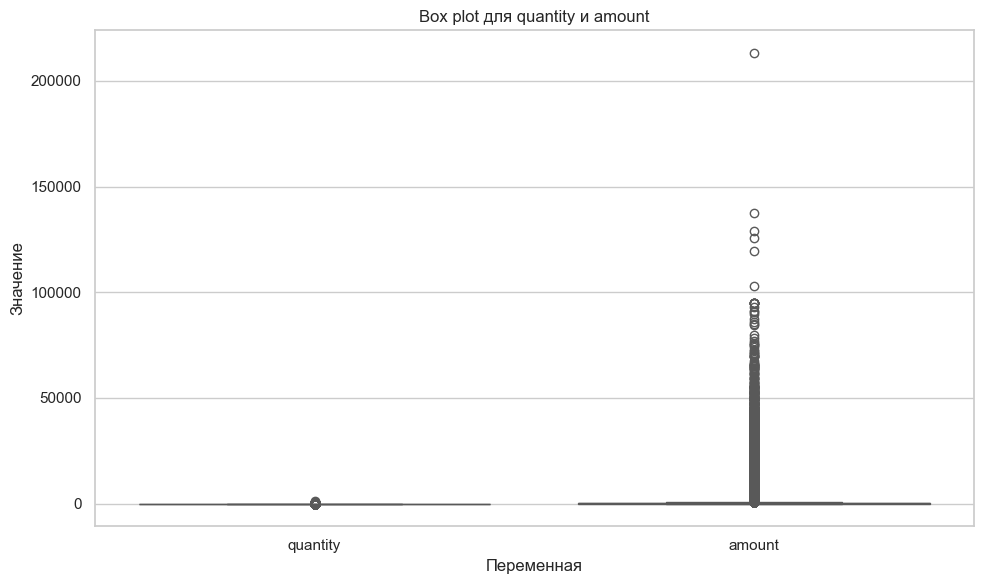

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Настройка стиля графиков
sns.set(style="whitegrid")

# === Окно 1: Гистограммы с KDE ===
plt.figure(figsize=(12, 5))

# Гистограмма для quantity
plt.subplot(1, 2, 1)
sns.histplot(df['quantity'], kde=True, bins=30, color='skyblue', stat="density")
plt.title('Распределение quantity (с KDE)')
plt.xlabel('Quantity')
plt.ylabel('Плотность')

# Гистограмма для amount
plt.subplot(1, 2, 2)
sns.histplot(df['amount'], kde=True, bins=30, color='salmon', stat="density")
plt.title('Распределение amount (с KDE)')
plt.xlabel('Amount')
plt.ylabel('Плотность')

# Оформление окна
plt.tight_layout()
plt.show()

# === Окно 2: Box plot для quantity и amount ===
plt.figure(figsize=(10, 6))

# Объединяем данные для boxplot
data_to_plot = df[['quantity', 'amount']].melt(value_name='value', var_name='variable')

# Построение boxplot
sns.boxplot(x='variable', y='value', data=data_to_plot, palette='Set2')
plt.title('Box plot для quantity и amount')
plt.xlabel('Переменная')
plt.ylabel('Значение')

# Отображение графика
plt.tight_layout()
plt.show()


In [38]:
# 1. Группировка по колонке 'item'
# 2. Расчет суммы quantity и amount
# 3. Сортировка по сумме продаж (amount) по убыванию
# 4. Выбор ТОП-5
top_5_products = (df.groupby('item')
                   .agg({'quantity': 'sum', 'amount': 'sum'})
                   .rename(columns={'quantity': 'total_quantity', 'amount': 'total_amount'})
                   .sort_values(by='total_amount', ascending=False)
                   .head(5))

# Вывод результата
print(top_5_products)


          total_quantity  total_amount
item                                  
sku26161           18902       5373638
sku18199            7250       3951361
sku21947           15304       3918570
sku28128            7705       3027786
sku8342             3512       2113158


In [39]:
def get_top_products(df, n=5):
    """
    Возвращает топ-N товаров по сумме продаж.
    
    Параметры:
    df (pd.DataFrame): DataFrame с колонками 'item', 'quantity', 'amount'
    n (int): Количество топ-товаров для возврата (по умолчанию 5)
    
    Возвращает:
    pd.DataFrame: Топ-N товаров с суммарным количеством и суммой продаж
    """
    top_products = (df.groupby('item')
                     .agg({'quantity': 'sum', 'amount': 'sum'})
                     .rename(columns={'quantity': 'total_quantity', 'amount': 'total_amount'})
                     .sort_values(by='total_amount', ascending=False)
                     .head(n))
    return top_products

# === Тестирование функции с разными значениями N ===

# Топ-5
print("=== Топ-5 товаров ===")
print(get_top_products(df, n=5))

# Топ-3
print("\n=== Топ-3 товара ===")
print(get_top_products(df, n=3))

# Топ-10
print("\n=== Топ-10 товаров ===")
print(get_top_products(df, n=10))


=== Топ-5 товаров ===
          total_quantity  total_amount
item                                  
sku26161           18902       5373638
sku18199            7250       3951361
sku21947           15304       3918570
sku28128            7705       3027786
sku8342             3512       2113158

=== Топ-3 товара ===
          total_quantity  total_amount
item                                  
sku26161           18902       5373638
sku18199            7250       3951361
sku21947           15304       3918570

=== Топ-10 товаров ===
          total_quantity  total_amount
item                                  
sku26161           18902       5373638
sku18199            7250       3951361
sku21947           15304       3918570
sku28128            7705       3027786
sku8342             3512       2113158
sku29626           13669       1973964
sku9018             3299       1706341
sku9471             5045       1675843
sku25074            6125       1668585
sku27791            8384       1645

In [1]:
import pandas as pd

# 1. Конечная дата
end_date = '2019-10-31'

# 2. Количество месяцев для периода
period_months = 6

# 3. Расчет начальной даты (вычитаем 6 месяцев)
# Используем pd.DateOffset для корректного вычитания месяцев
start_date = pd.to_datetime(end_date) - pd.DateOffset(months=period_months)

# 4. Фильтрация DataFrame по диапазону дат
# Убедимся, что tr_date — в формате datetime (уже должно быть)
filtered_df = df[(df['tr_date'] >= start_date) & (df['tr_date'] <= pd.to_datetime(end_date))]

# 5. Применение функции get_top_products к отфильтрованным данным
top_5_recent = get_top_products(filtered_df, n=5)

# 6. Вывод результата
print("=== Топ-5 товаров за последние 6 месяцев до 2019-10-31 ===")
print(top_5_recent)


NameError: name 'df' is not defined

In [ ]:
# 1. Группировка по правильной колонке 'client'
client_stats = df.groupby('client').agg(
    total_quantity=('quantity', 'sum'),           # общее количество товаров
    total_amount=('amount', 'sum'),               # общая сумма закупок
    unique_visits=('tr_date', 'nunique')          # количество уникальных дат визитов
).reset_index()

# 2. Сортировка по сумме закупок (по убыванию)
client_stats = client_stats.sort_values(by='total_amount', ascending=False)

# 3. Вывод статистики

print("=== Статистика по клиентам ===")

# Для total_quantity
print("\n--- total_quantity (количество товаров) ---")
print(f"min:    {client_stats['total_quantity'].min()}")
print(f"max:    {client_stats['total_quantity'].max()}")
print(f"mean:   {client_stats['total_quantity'].mean():.2f}")
print(f"median: {client_stats['total_quantity'].median()}")

# Для total_amount
print("\n--- total_amount (сумма закупок) ---")
print(f"min:    {client_stats['total_amount'].min()}")
print(f"max:    {client_stats['total_amount'].max()}")
print(f"mean:   {client_stats['total_amount'].mean():.2f}")
print(f"median: {client_stats['total_amount'].median()}")

# Для unique_visits
print("\n--- unique_visits (уникальные даты визитов) ---")
print(f"min:    {client_stats['unique_visits'].min()}")
print(f"max:    {client_stats['unique_visits'].max()}")
print(f"mean:   {client_stats['unique_visits'].mean():.2f}")


=== Статистика по клиентам ===

--- total_quantity (количество товаров) ---
min:    1
max:    5457
mean:   52.44
median: 21.0

--- total_amount (сумма закупок) ---
min:    10
max:    3887309
mean:   14705.66
median: 6410.0

--- unique_visits (уникальные даты визитов) ---
min:    1
max:    174
mean:   6.18


In [58]:
# 1. Фильтрация клиентов по условию:
#    quantity >= 2000 ИЛИ amount >= 500000
filtered_clients = client_stats[
    (client_stats['total_quantity'] >= 2000) |
    (client_stats['total_amount'] >= 500000)
]

# 2. Вывод количества и списка
print(f"=== Найдено клиентов, удовлетворяющих условиям: {len(filtered_clients)} ===")

# 3. Показать основные характеристики этих клиентов
print("\n--- Список клиентов и их характеристики ---")
print(filtered_clients.to_string(index=False))

# 4. Опционально: сохранить ID (или имена/идентификаторы клиентов) в список
extreme_clients = filtered_clients['client'].tolist()

print("\n--- Список ID/имён экстремальных клиентов (для дальнейшего анализа) ---")
print(extreme_clients)


=== Найдено клиентов, удовлетворяющих условиям: 9 ===

--- Список клиентов и их характеристики ---
     client  total_quantity  total_amount  unique_visits
client29182            3434       3887309            107
client15654            5457       1443255            174
 client8778            1617        986618             17
 client1704            1187        636101             23
client33032            1255        537397             74
client37582            2526        502515            159
client30977            2234        407138            121
client34081            2470        386355            157
client20310            3265        366035            102

--- Список ID/имён экстремальных клиентов (для дальнейшего анализа) ---
['client29182', 'client15654', 'client8778', 'client1704', 'client33032', 'client37582', 'client30977', 'client34081', 'client20310']


In [59]:
# 1. Фильтрация клиентов с количеством визитов == 1
one_visit_clients = client_stats[client_stats['unique_visits'] == 1]

# 2. Подсчет количества таких клиентов
num_one_visit = len(one_visit_clients)

# 3. Вывод статистики
print(f"=== Клиенты с одним визитом ===")
print(f"Количество клиентов, совершавших только один визит: {num_one_visit}")

if num_one_visit > 0:
    # Средний чек = средняя сумма покупки за визит (т.к. визит один, это и есть total_amount)
    avg_check = one_visit_clients['total_amount'].mean()
    
    # Средний объем покупок (среднее количество товаров)
    avg_quantity = one_visit_clients['total_quantity'].mean()
    
    print(f"Средний чек (средняя сумма покупки): {avg_check:.2f}")
    print(f"Средний объем покупок (количество товаров): {avg_quantity:.2f}")
else:
    print("Клиенты с одним визитом не найдены.")


=== Клиенты с одним визитом ===
Количество клиентов, совершавших только один визит: 12859
Средний чек (средняя сумма покупки): 3535.45
Средний объем покупок (количество товаров): 8.67


In [60]:
# 1. Проверка на строки с quantity = 0

# Подсчет строк, где quantity = 0
zero_quantity_rows = df[df['quantity'] == 0]

print(f"Количество строк с quantity = 0: {len(zero_quantity_rows)}")

if len(zero_quantity_rows) > 0:
    print("Примеры строк с quantity = 0:")
    print(zero_quantity_rows.head())
    print("Удаляем эти строки...")
    
    # Удаление строк с quantity = 0
    df = df[df['quantity'] != 0].copy()
else:
    print("Строк с quantity = 0 не найдено. Удаление не требуется.")

# 2. Создание столбца 'price' = amount / quantity
df['price'] = df['amount'] / df['quantity']

# 3. Статистика по столбцу 'price'
print("\n=== Статистика по новому столбцу 'price' ===")
price_col = df['price']
print(f"min:    {price_col.min():.2f}")
print(f"max:    {price_col.max():.2f}")
print(f"mean:   {price_col.mean():.2f}")
print(f"median: {price_col.median():.2f}")

# 4. Вывод первых 10 строк с новым столбцом
print("\n=== Первые 10 строк DataFrame с новым столбцом 'price' ===")
print(df[['tr_date', 'client', 'item', 'quantity', 'amount', 'price']].head(10))


Количество строк с quantity = 0: 1
Примеры строк с quantity = 0:
          tr_date          bcode       client      item        item_group  \
920771 2019-09-14  code000261741  client24307  sku26360  Скобяные изделия   

        quantity  amount  
920771         0       1  
Удаляем эти строки...

=== Статистика по новому столбцу 'price' ===
min:    0.00
max:    119500.00
mean:   389.78
median: 102.89

=== Первые 10 строк DataFrame с новым столбцом 'price' ===
     tr_date       client      item  quantity  amount  price
0 2017-09-01  client13166   sku8444         1      29   29.0
1 2017-09-01  client13166  sku12545         1     329  329.0
2 2017-09-01  client13166   sku3391         1     169  169.0
3 2017-09-01  client13166  sku20444         2     578  289.0
4 2017-09-01   client1239  sku29959         1     329  329.0
5 2017-09-01   client1239  sku19394         4     116   29.0
6 2017-09-01   client1239   sku9916         4     116   29.0
7 2017-09-01   client1239  sku27003         8    

=== Описательная статистика по 'price' ===
Минимум:           0.00
25% (Q1):          39.00
50% (медиана):     102.89
75% (Q3):          269.00
Максимум:          119500.00
Межквартильный размах (IQR): 230.00
Нижняя граница выбросов:    -306.00
Верхняя граница выбросов:   614.00

Количество выбросов: 112596

=== 10 самых дешёвых выбросов ===
            item       price       client  quantity  amount
393100  sku17951  614.142857  client10939        14    8598
393099  sku16711  614.166667  client10939        12    7370
499700  sku18205  614.500000  client18828        14    8603
560204   sku1112  614.500000  client17879         2    1229
693758  sku18389  614.666667  client29182         6    3688
353878   sku7572  614.666667   client5794         3    1844
643756  sku19659  614.750000   client2181         4    2459
867779  sku10097  614.800000  client24120         5    3074
476533  sku19659  614.833333  client21461         6    3689
906730  sku19659  614.833333  client30443         6    3

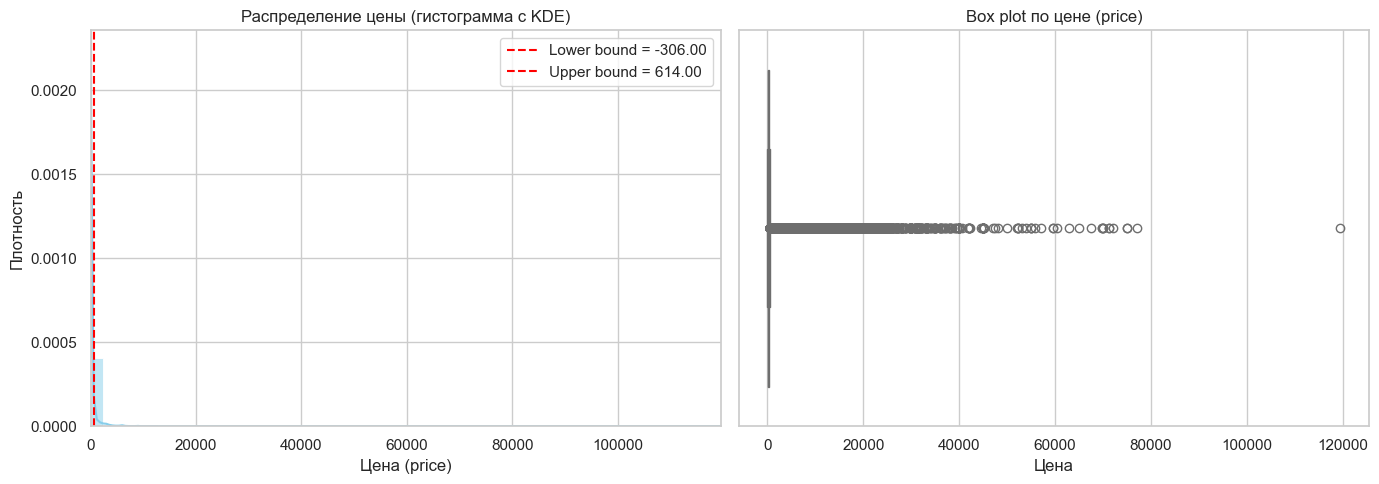

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Описательная статистика и квартили
price = df['price']
q1 = price.quantile(0.25)
q3 = price.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("=== Описательная статистика по 'price' ===")
print(f"Минимум:           {price.min():.2f}")
print(f"25% (Q1):          {q1:.2f}")
print(f"50% (медиана):     {price.median():.2f}")
print(f"75% (Q3):          {q3:.2f}")
print(f"Максимум:          {price.max():.2f}")
print(f"Межквартильный размах (IQR): {iqr:.2f}")
print(f"Нижняя граница выбросов:    {lower_bound:.2f}")
print(f"Верхняя граница выбросов:   {upper_bound:.2f}")

# 2. Фильтрация выбросов
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"\nКоличество выбросов: {len(outliers)}")

# 3. Примеры выбросов
print("\n=== 10 самых дешёвых выбросов ===")
print(outliers.sort_values(by='price').head(10)[['item', 'price', 'client', 'quantity', 'amount']])

print("\n=== 10 самых дорогих выбросов ===")
print(outliers.sort_values(by='price', ascending=False).head(10)[['item', 'price', 'client', 'quantity', 'amount']])

# 4. Визуализация
plt.figure(figsize=(14, 5))

# Гистограмма с KDE
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=50, color='skyblue', stat="density")
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound = {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound = {upper_bound:.2f}')
plt.title('Распределение цены (гистограмма с KDE)')
plt.xlabel('Цена (price)')
plt.ylabel('Плотность')
plt.legend()
plt.xlim(df['price'].min(), df['price'].max())

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'], color='lightcoral')
plt.title('Box plot по цене (price)')
plt.xlabel('Цена')

plt.tight_layout()
plt.show()


In [62]:
# 1. Группировка по товару и расчет суммы продаж
sales_by_item = df.groupby('item')['amount'].sum().reset_index(name='total_sales')

# 2. Сортировка по сумме продаж по убыванию
sales_by_item = sales_by_item.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

# 3. Расчет накопительного процента
total_sum = sales_by_item['total_sales'].sum()
sales_by_item['cumulative_sum'] = sales_by_item['total_sales'].cumsum()
sales_by_item['cumulative_percent'] = (sales_by_item['cumulative_sum'] / total_sum) * 100

# 4. Присвоение группы A, B, C
def assign_abc_group(percent):
    if percent <= 80:
        return 'A'
    elif percent <= 95:
        return 'B'
    else:
        return 'C'

sales_by_item['ABC_group'] = sales_by_item['cumulative_percent'].apply(assign_abc_group)

# 5. Вывод результатов
print("=== Результаты ABC-анализа по товарам ===")

# Количество товаров в каждой группе
group_counts = sales_by_item['ABC_group'].value_counts().sort_index()
print(f"Количество товаров по группам:")
print(f"Группа A (до 80%): {group_counts.get('A', 0)}")
print(f"Группа B (80–95%): {group_counts.get('B', 0)}")
print(f"Группа C (95–100%): {group_counts.get('C', 0)}")

# Примеры товаров из каждой группы
print("\n--- Примеры товаров из группы A (ТОП-выручка) ---")
print(sales_by_item[sales_by_item['ABC_group'] == 'A'][['item', 'total_sales', 'cumulative_percent']].head(10))

print("\n--- Примеры товаров из группы B ---")
print(sales_by_item[sales_by_item['ABC_group'] == 'B'][['item', 'total_sales', 'cumulative_percent']].head(10))

print("\n--- Примеры товаров из группы C (низкая выручка) ---")
print(sales_by_item[sales_by_item['ABC_group'] == 'C'][['item', 'total_sales', 'cumulative_percent']].head(10))


=== Результаты ABC-анализа по товарам ===
Количество товаров по группам:
Группа A (до 80%): 5353
Группа B (80–95%): 8234
Группа C (95–100%): 16979

--- Примеры товаров из группы A (ТОП-выручка) ---
       item  total_sales  cumulative_percent
0  sku26161      5373638            0.854847
1  sku18199      3951361            1.483435
2  sku21947      3918570            2.106808
3  sku28128      3027786            2.588473
4   sku8342      2113158            2.924637
5  sku29626      1973964            3.238658
6   sku9018      1706341            3.510106
7   sku9471      1675843            3.776702
8  sku25074      1668585            4.042143
9  sku27791      1645042            4.303839

--- Примеры товаров из группы B ---
          item  total_sales  cumulative_percent
5353  sku10822        22836           80.001791
5354  sku10724        22834           80.005424
5355  sku29015        22826           80.009055
5356  sku26094        22824           80.012686
5357  sku19581        22817   

In [63]:
# Выполняем XYZ-анализ по количеству покупок товара (quantity)

# 1. Группировка по товару и расчет среднего и стандартного отклонения количества
xyz_data = df.groupby('item')['quantity'].agg(['mean', 'std']).reset_index()

# Переименуем столбцы
xyz_data = xyz_data.rename(columns={'mean': 'qty_mean', 'std': 'qty_std'})

# 2. Расчет коэффициента вариации (CV) в процентах
# Обработка случаев, где mean = 0 (избежание деления на 0)
xyz_data['cv'] = xyz_data.apply(
    lambda row: (row['qty_std'] / row['qty_mean']) * 100 if row['qty_mean'] > 0 else 0, axis=1
)

# Заполним NaN (если std был NaN, например, у товара одна покупка)
xyz_data['cv'] = xyz_data['cv'].fillna(0)

# 3. Присвоение группы XYZ на основе CV
def assign_xyz_group(cv):
    if cv < 15:
        return 'X'
    elif 15 <= cv <= 25:
        return 'Y'
    else:
        return 'Z'

xyz_data['XYZ_group'] = xyz_data['cv'].apply(assign_xyz_group)

# 4. Вывод результатов
print("=== Результаты XYZ-анализа по стабильности продаж (по quantity) ===")
group_counts = xyz_data['XYZ_group'].value_counts().sort_index()
print(f"Количество товаров по группам:")
print(f"Группа X (CV < 15%):   {group_counts.get('X', 0)} — стабильный спрос")
print(f"Группа Y (15% <= CV <= 25%): {group_counts.get('Y', 0)} — умеренно изменчивый")
print(f"Группа Z (CV > 25%):   {group_counts.get('Z', 0)} — высокая вариативность, непредсказуемый спрос")

# 5. Итоговый датафрейм (можно объединить с ABC-анализом в будущем)
print("\n=== Итоговый датафрейм XYZ-анализа (первые 15 строк) ===")
print(xyz_data[['item', 'qty_mean', 'qty_std', 'cv', 'XYZ_group']].head(15))

# Опционально: сохранение результата
xyz_result = xyz_data[['item', 'qty_mean', 'qty_std', 'cv', 'XYZ_group']].copy()


=== Результаты XYZ-анализа по стабильности продаж (по quantity) ===
Количество товаров по группам:
Группа X (CV < 15%):   11655 — стабильный спрос
Группа Y (15% <= CV <= 25%): 1354 — умеренно изменчивый
Группа Z (CV > 25%):   17557 — высокая вариативность, непредсказуемый спрос

=== Итоговый датафрейм XYZ-анализа (первые 15 строк) ===
        item  qty_mean   qty_std          cv XYZ_group
0       sku1  1.375000  0.517549   37.639940         Z
1      sku10  2.000000  1.224745   61.237244         Z
2     sku100  1.396552  0.883465   63.260430         Z
3    sku1000  1.268293  0.667569   52.635279         Z
4   sku10000  2.483871  2.908275  117.086403         Z
5   sku10001  2.000000  2.408319  120.415946         Z
6   sku10002  1.000000  0.000000    0.000000         X
7   sku10003  1.000000  0.000000    0.000000         X
8   sku10004  4.333333  6.218253  143.498139         Z
9   sku10005  1.000000  0.000000    0.000000         X
10  sku10006  2.000000       NaN    0.000000         X
11 

=== Матрица ABC-XYZ (количество товаров в каждой группе) ===
XYZ        X     Y      Z  Total
ABC                             
A       1527   297   3529   5353
B       2562   411   5261   8234
C       7566   646   8767  16979
Total  11655  1354  17557  30566


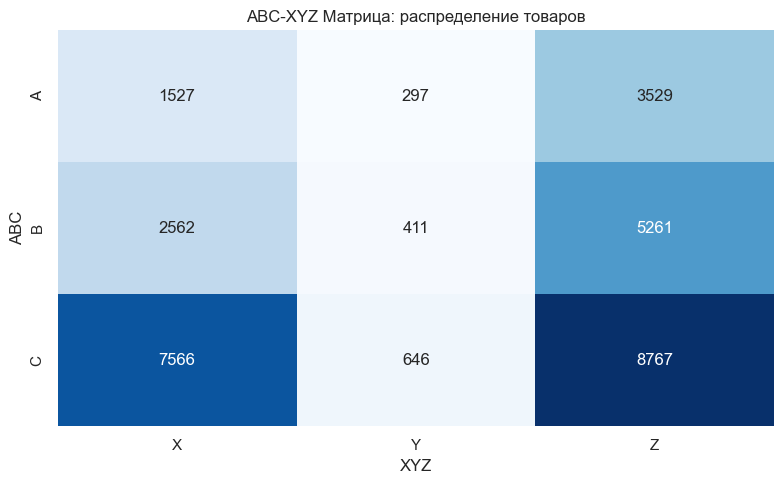

In [64]:
# Объединим результаты ABC- и XYZ-анализов по колонке 'item'
abc_xyz_combined = pd.merge(
    sales_by_item[['item', 'ABC_group']],   # Результаты ABC-анализа
    xyz_result[['item', 'XYZ_group']],      # Результаты XYZ-анализа
    on='item'
)

# Создаем сводную таблицу (pivot table) — количество товаров в каждой комбинации
abc_xyz_pivot = pd.crosstab(
    abc_xyz_combined['ABC_group'],
    abc_xyz_combined['XYZ_group'],
    rownames=['ABC'],
    colnames=['XYZ'],
    margins=True,           # Добавляет итоговые строки/столбцы
    margins_name='Total'
)

# Вывод матрицы
print("=== Матрица ABC-XYZ (количество товаров в каждой группе) ===")
print(abc_xyz_pivot)

# Опционально: визуализация в виде тепловой карты
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(
    abc_xyz_pivot.iloc[:-1, :-1],  # Без итогов для чистоты визуализации
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.title("ABC-XYZ Матрица: распределение товаров")
plt.tight_layout()
plt.show()


In [69]:
import pandas as pd

def abc_xyz_analysis(df, abc_threshold_a=80, abc_threshold_b=95):
    """
    Полный ABC-XYZ анализ по товарам.
    
    Параметры:
    df (pd.DataFrame): исходный DataFrame с колонками 'item', 'quantity', 'amount'
    abc_threshold_a (float): верхняя граница группы A (по умолчанию 80%)
    abc_threshold_b (float): верхняя граница группы B (по умолчанию 95%)
    
    Возвращает:
    pd.DataFrame: таблица с item, ABC_group, XYZ_group
    """
    # --- ABC-анализ по сумме продаж ---
    abc_data = df.groupby('item')['amount'].sum().reset_index(name='total_sales')
    abc_data = abc_data.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
    
    total_sales = abc_data['total_sales'].sum()
    abc_data['cumulative_sum'] = abc_data['total_sales'].cumsum()
    abc_data['cumulative_percent'] = (abc_data['cumulative_sum'] / total_sales) * 100
    
    def assign_abc_group(p):
        if p <= abc_threshold_a:
            return 'A'
        elif p <= abc_threshold_b:
            return 'B'
        else:
            return 'C'
    
    abc_data['ABC_group'] = abc_data['cumulative_percent'].apply(assign_abc_group)
    abc_result = abc_data[['item', 'ABC_group']].copy()
    
    # --- XYZ-анализ по стабильности количества ---
    xyz_data = df.groupby('item')['quantity'].agg(['mean', 'std']).reset_index()
    xyz_data['cv'] = xyz_data.apply(
        lambda row: (row['std'] / row['mean']) * 100 if row['mean'] > 0 else 0, axis=1
    )
    xyz_data['cv'] = xyz_data['cv'].fillna(0)
    
    def assign_xyz_group(cv):
        if cv < 15:
            return 'X'
        elif 15 <= cv <= 25:
            return 'Y'
        else:
            return 'Z'
    
    xyz_data['XYZ_group'] = xyz_data['cv'].apply(assign_xyz_group)
    xyz_result = xyz_data[['item', 'XYZ_group']].copy()
    
    # --- Объединение ABC и XYZ ---
    result = pd.merge(abc_result, xyz_result, on='item', how='inner')
    return result


# === 1. Фильтрация данных за последние 6 месяцев: с 2019-05-01 по 2019-10-31 ===
df['tr_date'] = pd.to_datetime(df['tr_date'])  # Убедимся, что дата в нужном формате

start_date = '2019-05-01'
end_date = '2019-10-31'
df_last_6m = df[(df['tr_date'] >= start_date) & (df['tr_date'] <= end_date)]

# === 2. Запуск ABC-XYZ анализа для всего периода и последних 6 месяцев ===
full_period_result = abc_xyz_analysis(df)
recent_period_result = abc_xyz_analysis(df_last_6m)

# Переименуем колонки для объединения
full_period_result = full_period_result.rename(columns={'ABC_group': 'ABC_full', 'XYZ_group': 'XYZ_full'})
recent_period_result = recent_period_result.rename(columns={'ABC_group': 'ABC_recent', 'XYZ_group': 'XYZ_recent'})

# === 3. Сравнение результатов (только товары, присутствующие в обоих периодах) ===
# Объединение результатов для сравнения
comparison = pd.merge(
    full_period_result,
    recent_period_result,
    on='item',
    how='inner'
)

# Сравнение: какие товары изменили группу
comparison['abc_changed'] = comparison['ABC_full'] != comparison['ABC_recent']
comparison['xyz_changed'] = comparison['XYZ_full'] != comparison['XYZ_recent']
comparison['any_changed'] = comparison['abc_changed'] | comparison['xyz_changed']  # ← Исправлено!

# Статистика изменений
print("=== Сравнение ABC-XYZ групп: полный период vs последние 6 месяцев ===")
print(f"Всего товаров в обоих периодах: {len(comparison)}")
print(f"Товаров, изменивших ABC-группу: {comparison['abc_changed'].sum()}")
print(f"Товаров, изменивших XYZ-группу: {comparison['xyz_changed'].sum()}")
print(f"Товаров, изменивших хотя бы одну группу: {comparison['any_changed'].sum()}")

# Примеры: стали важнее (ABC: C/B → A или A/B → B/A)
print("\n--- Примеры товаров, ставших важнее (в ABC: улучшили позиции) ---")
better_abc = comparison[
    (comparison['ABC_full'].isin(['B', 'C'])) & 
    (comparison['ABC_recent'] == 'A')
]
print(better_abc[['item', 'ABC_full', 'ABC_recent', 'XYZ_full', 'XYZ_recent']].head(10))

print("\n--- Примеры товаров, ставших менее важными (в ABC: A/B → C/B) ---")
worse_abc = comparison[
    (comparison['ABC_full'] == 'A') & 
    (comparison['ABC_recent'].isin(['B', 'C']))
]
print(worse_abc[['item', 'ABC_full', 'ABC_recent', 'XYZ_full', 'XYZ_recent']].head(10))

# Опционально: сохранение результата сравнения
comparison.to_csv('abc_xyz_comparison.csv', index=False)
print("\nРезультат сохранён в файл 'abc_xyz_comparison.csv'")


=== Сравнение ABC-XYZ групп: полный период vs последние 6 месяцев ===
Всего товаров в обоих периодах: 21767
Товаров, изменивших ABC-группу: 4302
Товаров, изменивших XYZ-группу: 4220
Товаров, изменивших хотя бы одну группу: 7527

--- Примеры товаров, ставших важнее (в ABC: улучшили позиции) ---
          item ABC_full ABC_recent XYZ_full XYZ_recent
4521  sku10822        B          A        Z          Z
4522  sku10724        B          A        Z          Z
4532   sku6205        B          A        Z          Z
4533   sku8514        B          A        X          X
4538  sku25184        B          A        Y          Y
4539  sku24011        B          A        X          X
4540   sku8546        B          A        Z          Z
4541  sku21059        B          A        Z          Z
4545  sku21101        B          A        Z          Z
4548  sku17242        B          A        X          X

--- Примеры товаров, ставших менее важными (в ABC: A/B → C/B) ---
         item ABC_full ABC_recent

In [73]:
# ABC-анализ (повторяем для создания abc_result)

# Группировка по товару
sales_by_item = df.groupby('item')['amount'].sum().reset_index(name='total_sales')
sales_by_item = sales_by_item.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

# Кумулятивный процент
total_sum = sales_by_item['total_sales'].sum()
sales_by_item['cumulative_sum'] = sales_by_item['total_sales'].cumsum()
sales_by_item['cumulative_percent'] = (sales_by_item['cumulative_sum'] / total_sum) * 100

# Присвоение группы ABC
def assign_abc_group(percent):
    if percent <= 80:
        return 'A'
    elif percent <= 95:
        return 'B'
    else:
        return 'C'

sales_by_item['ABC_group'] = sales_by_item['cumulative_percent'].apply(assign_abc_group)

# Сохраняем результат
abc_result = sales_by_item[['item', 'ABC_group']].copy()


In [74]:
# Пример проверки
print("top_5_products:")
print(top_5_products.head())

print("\nclient_stats:")
print(client_stats.head())

print("\nabc_result:")
print(abc_result.head())

print("\nxyz_result:")
print(xyz_result.head())

print("\nabc_xyz_pivot:")
print(abc_xyz_pivot.head())

print("\ndf_last_6m:")
print(df_last_6m.head())


top_5_products:
          total_quantity  total_amount
item                                  
sku26161           18902       5373638
sku18199            7250       3951361
sku21947           15304       3918570
sku28128            7705       3027786
sku8342             3512       2113158

client_stats:
            client  total_quantity  total_amount  unique_visits
21313  client29182            3434       3887309            107
6283   client15654            5457       1443255            174
41389   client8778            1617        986618             17
7823    client1704            1187        636101             23
25592  client33032            1255        537397             74

abc_result:
       item ABC_group
0  sku26161         A
1  sku18199         A
2  sku21947         A
3  sku28128         A
4   sku8342         A

xyz_result:
       item  qty_mean   qty_std          cv XYZ_group
0      sku1  1.375000  0.517549   37.639940         Z
1     sku10  2.000000  1.224745   61.237244   

In [ ]:
# Сохранение файлов
top_5_products.to_csv('top_5_products.csv', index=False)
client_stats.to_csv('client_statistics.csv', index=False)
abc_result.to_csv('abc_analysis.csv', index=False)
xyz_result.to_csv('xyz_analysis.csv', index=False)
abc_xyz_pivot.to_csv('abc_xyz_matrix.csv', index=True)  # индекс (ABC) — часть данных
df_last_6m.to_csv('last_6_months_data.csv', index=False)

print("✅ Все файлы успешно созданы!")


✅ Все файлы успешно созданы!


In [77]:
import os

files = [
    'top_5_products.csv',
    'client_statistics.csv',
    'abc_analysis.csv',
    'xyz_analysis.csv',
    'abc_xyz_matrix.csv',
    'last_6_months_data.csv'
]

print("📊 Статус файлов:")
for file in files:
    if os.path.exists(file):
        size = os.path.getsize(file)
        print(f"🟢 {file} — создан, размер: {size} байт")
    else:
        print(f"🔴 {file} — НЕ найден!")


📊 Статус файлов:
🟢 top_5_products.csv — создан, размер: 101 байт
🟢 client_statistics.csv — создан, размер: 984580 байт
🟢 abc_analysis.csv — создан, размер: 355713 байт
🟢 xyz_analysis.csv — создан, размер: 1450827 байт
🟢 abc_xyz_matrix.csv — создан, размер: 114 байт
🟢 last_6_months_data.csv — создан, размер: 31539485 байт
